# 基于决策树的语音性别识别

参考：https://www.kaggle.com/primaryobjects/voicegender/notebooks?datasetId=134&sortBy=voteCounta

In [78]:
# 计算工具库
import numpy as np                  
import  pandas as pd
# 可视化工具库
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# 机器学习工具包
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn.metrics import roc_curve,auc,accuracy_score,recall_score
from sklearn.model_selection import StratifiedKFold

# 算法库
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neural_network
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# 数据分析

In [34]:
#读取数据
voice = pd.read_csv('data/voice.csv')
voice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [35]:
voice.head(5)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [36]:
# Convert string label to float : male = 1, female = 0
dict = {'label':{'male':1,'female':0}}      # label = column name
voice.replace(dict,inplace = True)           # replace = str to numerical

In [37]:
# 对性别标签进行编码
# le = preprocessing.LabelEncoder()
# voice["label"] = le.fit_transform(voice["label"])
# voice[:]=preprocessing.MinMaxScaler().fit_transform(voice)
# voice.head(5)

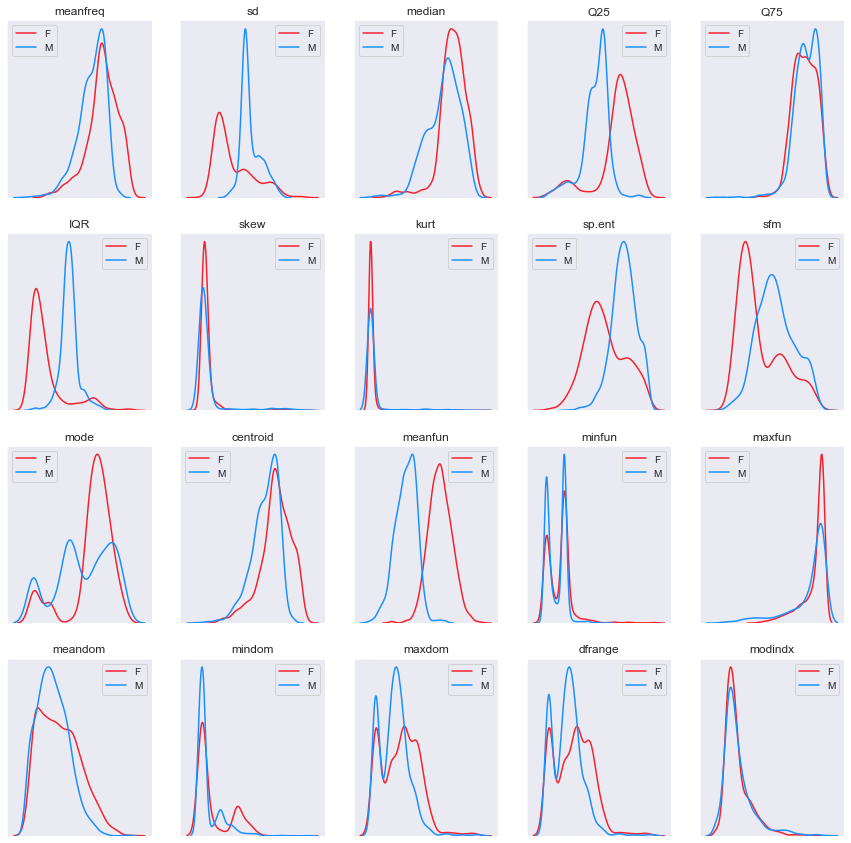

In [38]:
# 绘制密度曲线图
sns.set_style("darkgrid")
plt.subplots(4,5,figsize=(15,15))
for i in range(1,21):
    plt.subplot(4,5,i)
    plt.title(voice.columns[i-1])
    sns.kdeplot(voice.loc[voice['label'] == 0, voice.columns[i-1]], color= '#f5222d', label='F')
    sns.kdeplot(voice.loc[voice['label'] == 1, voice.columns[i-1]], color= '#1890ff', label='M')
    plt.legend()
    plt.xticks([]),plt.yticks([])  #去除坐标轴
    plt.xlabel('')
    plt.ylabel('')

特征选取：sd,Q25,IQR,sp.ent,sfm,mode,meanfun

In [65]:
voice_cut = voice[['sd','Q25','IQR','sp.ent','sfm','mode','meanfun','label']]
voice_cut.head()

,sd,Q25,IQR,sp.ent,sfm,mode,meanfun,label
0,0.064241,0.015071,0.075122,0.893369,0.491918,0.000000,0.084279,1
1,0.067310,0.019414,0.073252,0.892193,0.513724,0.000000,0.107937,1
2,0.083829,0.008701,0.123207,0.846389,0.478905,0.000000,0.098706,1
3,0.072111,0.096582,0.111374,0.963322,0.727232,0.083878,0.088965,1
4,0.079146,0.078720,0.127325,0.971955,0.783568,0.104261,0.106398,1


# 降维分析

In [120]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data.iloc[:,:-1])
pca_res = pca.transform(data.iloc[:,:-1])

In [122]:
# 数据合并 ： 加上类别
data = pd.concat([pd.DataFrame(pca_res), data['label']], axis=1)
data.columns = ['feature1', 'feature2', 'category']
data.head(5)

,feature1,feature2,category
0,238.081294,-4.802247,1
1,598.396593,-1.021374,1
2,988.762667,3.022605,1
3,-32.368181,-6.639116,1
4,-32.286811,0.339167,1


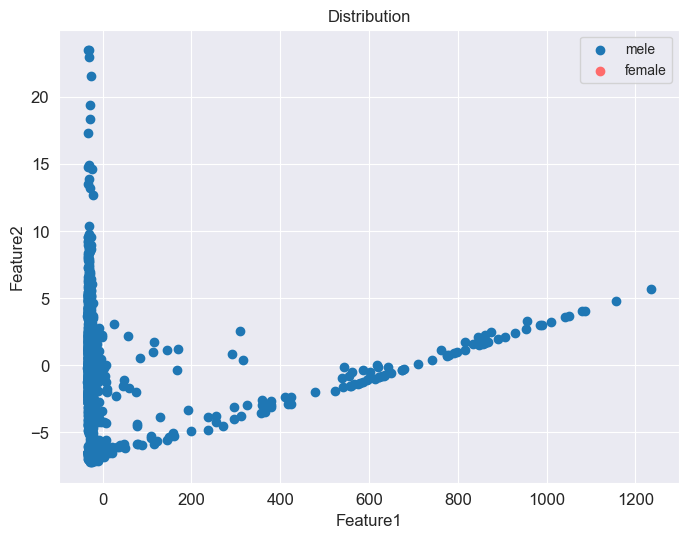

In [124]:
cate1_df = data.loc[data['category']==1]
cate2_df = data.loc[data['category']==2]
# 二元高斯概率分布图水平面投影
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(cate1_df.feature1, cate1_df.feature2)
plt.scatter(cate2_df.feature1, cate2_df.feature2,color='#ff6b6b')
plt.xlabel('Feature1',fontsize=12)
plt.ylabel('Feature2',fontsize=12) 
plt.title('Distribution',fontsize=12)
plt.legend(["mele","female"])
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

In [102]:
data = voice

# 划分

In [103]:
train, test = train_test_split(data, test_size=0.3) #7：3划分训练集和数据集

#使用所有的变量来训练
x_train = train.iloc[:,:-1]
y_train = train["label"]
x_test = test.iloc[:,:-1]
y_test = test["label"]

# 训练

In [113]:
# 模型选择

# clf = tree.DecisionTreeClassifier() # 决策树

# random_state = np.random.RandomState(0) 
# clf = RandomForestClassifier(random_state=random_state) # 随机森林

# 支持向量机
clf = svm.SVC(kernel='linear', C=10)

In [114]:
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

# 评估

1. 准确率

分类准确率分数是指所有分类正确的百分比。分类准确率这一衡量分类器的标准比较容易理解，但是它不能告诉你响应值的潜在分布，并且它也不能告诉你分类器犯错的类型。

In [115]:
accuracy_score(y_test, y_pred)

0.9789695057833859

2. 召回率

召回率 = 提取出的正确信息条数 / 样本中的信息条数。通俗地说，就是所有准确的条目有多少被检索出来了。

In [116]:
recall_score(y_test, y_pred, average='macro')

0.9791566714643638

3. ROC曲线

In [69]:
x = data.loc[:, data.columns != 'label']
y = data.loc[:,'label']

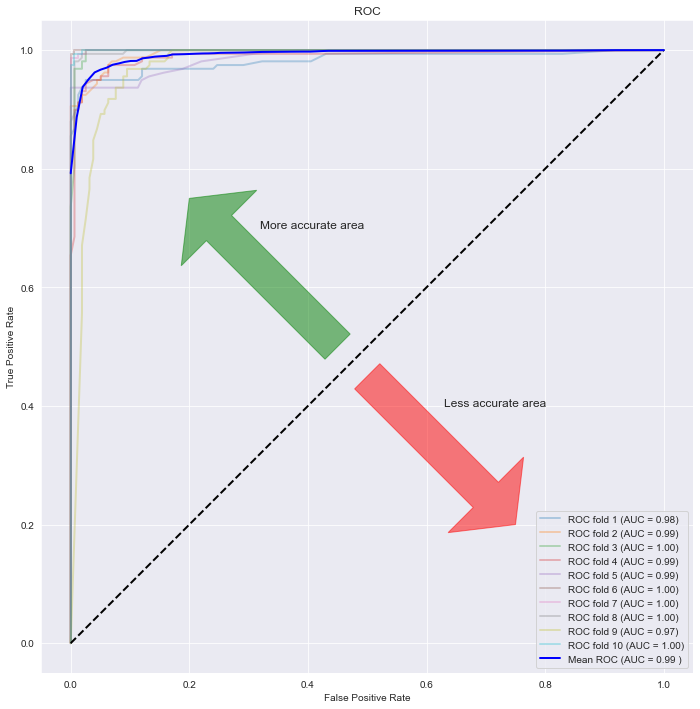

In [71]:
# plot arrows
cv = StratifiedKFold(n_splits=10,shuffle=False)
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()